In [25]:
# Importing the libraries we'll be using for this project
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, RocCurveDisplay


In [9]:
# load in database and split as neccessary
df = pd.read_csv('database.csv')
# Splitting the training data into appropriate training and validation sets
X = df.drop(columns = ["Diff","date","Unnamed: 0"])

y = df[['Diff']]
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42)

In [27]:
#Create a random forest pipeline
randomforest_pipeline = Pipeline(steps = [
    ('data_scaling', StandardScaler()),
    ('model', RandomForestClassifier(max_depth = 30,
                                     min_samples_leaf = 3,
                                     min_samples_split = 4,
                                     n_estimators = 200))
])

In [28]:
#train random forest pipeline
randomforest_pipeline.fit(X_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('data_scaling', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=30, min_samples_leaf=3,
                                        min_samples_split=4,
                                        n_estimators=200))])

Accuracy Score: 0.5220883534136547
ROC AUC Score: 0.5067251461988305


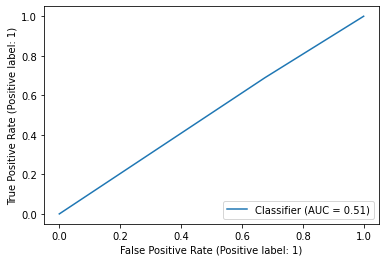

In [29]:
# Saving our pipeline to a binary pickle file
joblib.dump(randomforest_pipeline, 'model/randomforest_pipeline.pkl')

loaded_model = randomforest_pipeline

pipeline_preds = loaded_model.predict(X_val)
val_accuracy = accuracy_score(y_val, pipeline_preds)
val_roc_auc = roc_auc_score(y_val, pipeline_preds)

print(f'Accuracy Score: {val_accuracy}')
print(f'ROC AUC Score: {val_roc_auc}') 

RocCurveDisplay.from_predictions(y_val, pipeline_preds)
plt.show()

In [31]:
# Lets try a boosting model now
from sklearn.ensemble import HistGradientBoostingClassifier
boostingPipeline = Pipeline(steps = [
    ('data_scaling', StandardScaler()),
    ('model', HistGradientBoostingClassifier(loss = "auto",))
])

In [32]:
boostingPipeline.fit(X_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('data_scaling', StandardScaler()),
                ('model', HistGradientBoostingClassifier())])

Accuracy Score: 0.4779116465863454
ROC AUC Score: 0.4673489278752436


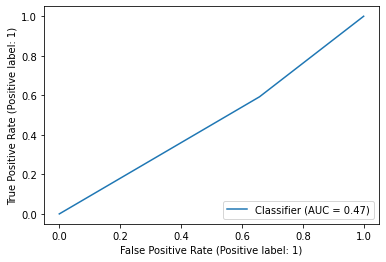

In [33]:
# Saving our pipeline to a binary pickle file
joblib.dump(boostingPipeline, 'model/boostingPipeline.pkl')

loaded_model = boostingPipeline

pipeline_preds = loaded_model.predict(X_val)
val_accuracy = accuracy_score(y_val, pipeline_preds)
val_roc_auc = roc_auc_score(y_val, pipeline_preds)

print(f'Accuracy Score: {val_accuracy}')
print(f'ROC AUC Score: {val_roc_auc}') 

RocCurveDisplay.from_predictions(y_val, pipeline_preds)
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.5461847389558233
ROC AUC Score: 0.5187134502923977


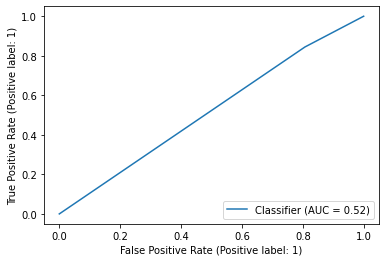

In [36]:
#logistic Regression with cross validation
from sklearn.linear_model import LogisticRegressionCV
lr_pipeline = Pipeline(steps = [
    ('data_scaling', StandardScaler()),
    ('model', LogisticRegressionCV(cv = 10))#10 cross validation
])

lr_pipeline.fit(X_train,y_train)

joblib.dump(lr_pipeline, 'model/lr_pipeline.pkl')

loaded_model = lr_pipeline

pipeline_preds = loaded_model.predict(X_val)
val_accuracy = accuracy_score(y_val, pipeline_preds)
val_roc_auc = roc_auc_score(y_val, pipeline_preds)

print(f'Accuracy Score: {val_accuracy}')
print(f'ROC AUC Score: {val_roc_auc}') 

RocCurveDisplay.from_predictions(y_val, pipeline_preds)
plt.show()

Accuracy Score: 0.5341365461847389
ROC AUC Score: 0.5171539961013645


/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


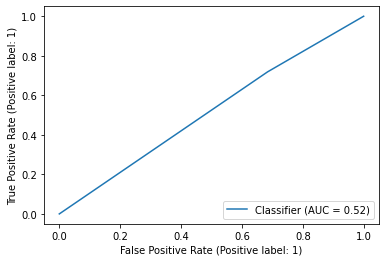

In [37]:
#k nearest neighbors classifier
from sklearn.neighbors import KNeighborsClassifier

knnc_pipeline = Pipeline(steps = [
    ('data_scaling', StandardScaler()),
    ('model', KNeighborsClassifier(n_neighbors=15))#10 cross validation
])

knnc_pipeline.fit(X_train,y_train)

joblib.dump(knnc_pipeline, 'model/knnc_pipeline.pkl')

loaded_model = knnc_pipeline

pipeline_preds = loaded_model.predict(X_val)
val_accuracy = accuracy_score(y_val, pipeline_preds)
val_roc_auc = roc_auc_score(y_val, pipeline_preds)

print(f'Accuracy Score: {val_accuracy}')
print(f'ROC AUC Score: {val_roc_auc}') 

RocCurveDisplay.from_predictions(y_val, pipeline_preds)
plt.show()